# Multi-Agentic Recommendation System Pipeline
This notebook demonstrates a modular, multi-agentic pipeline for evaluating recommender systems with context engineering.

Each agent is responsible for a specific function, and context engineering is used to enhance the recommendation process.

In [1]:
# Go to root dir to load the code from `src` and dataset from the specific folder
import os
os.chdir("..")

In [2]:
# Import required libraries
import pandas as pd
import numpy as np
import torch

from scipy.sparse import lil_matrix

from prettytable import PrettyTable

from recpack.preprocessing.preprocessors import DataFramePreprocessor
from recpack.preprocessing.filters import Deduplicate, MinRating, MinItemsPerUser
from recpack.scenarios import WeakGeneralization, StrongGeneralization

from hyperopt import fmin, tpe, hp

# helpers & metrics
from src.helper_functions.data_formatting import *
from src.helper_functions.metrics_accuracy import *
from src.helper_functions.metrics_coverage import *
from src.helper_functions.metrics_exposure import *

# models
from src.recommenders.ease import myEASE
from src.recommenders.slim_bn import BNSLIM
from src.recommenders.fslr import FSLR
from src.recommenders.slim_bn_admm import BNSLIM_ADMM
from src.recommenders.mf_fair import FairMF
from src.recommenders.fda import FDA_bpr

import json
import re
import itertools
import time
# import pickle

/Users/eas/Documents/GitHub/fair_neighborhood/venv/lib/python3.11/site-packages/hyperopt/atpe.py:19: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


### Data loading

In [3]:
# load ratings.dat from ml-1m folder
ratings = pd.read_csv("ml-1m/ratings.dat", sep="::", header=None, usecols=[0,1,2,3], names=["User_id","Item_id","Rating","Timestamp"], engine="python")

# load movies.dat from ml-1m folder
movies = pd.read_csv("ml-1m/movies.dat", sep="::", header=None, usecols=[0,1,2], names=["Item_id", "Title", "Genre"], encoding="latin-1", engine="python")
movies["Genre"] = movies["Genre"].apply(lambda x: x.split("|"))
movies_items = movies
movies = movies.explode("Genre")

# load users.dat from ml-1m folder
users = pd.read_csv("ml-1m/users.dat", sep="::", header=None, usecols=[0,1], names=["User_id", "Gender"], encoding="latin-1", engine="python")

# replace "M" with 0 and "F" with 1 in the "Gender" column
users["Gender"] = users["Gender"].replace({"M": 0, "F": 1})

# join ratings on users with User_id
ratings = pd.merge(ratings, users, on="User_id", how="left")
ratings['datetime'] = pd.to_datetime(ratings['Timestamp'], unit='s')
ratings = ratings.sort_values('datetime').reset_index(drop=True)

/var/folders/p_/s2y5jw396vjd9c8fql74n7600000gn/T/ipykernel_30272/2820513550.py:14: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  users["Gender"] = users["Gender"].replace({"M": 0, "F": 1})


### Data Preprocessing

#### Temporal Splitting

Split the dataset into train and test sets based on a timestamp for temporal evaluation.

* 50% oldest interactions for train (base set)
* 50% newest interactions for test

In [4]:
# Split ratings into train and test sets based on timestamp (temporal split)
# Example: Use the 80th percentile of timestamps as the split point
#split_point = ratings["Timestamp"].quantile(0.8)
split_point = ratings["Timestamp"].quantile(0.5) # 50% temporal split
train_ratings = ratings[ratings["Timestamp"] <= split_point]
test_ratings = ratings[ratings["Timestamp"] > split_point]

print(f"Train set size: {len(train_ratings)}")
print(f"Test set size: {len(test_ratings)}")
print(f"Split timestamp: {split_point}")
print(f"Split datetime: {pd.to_datetime(split_point, unit='s')}")


Train set size: 500105
Test set size: 500104
Split timestamp: 973018006.0
Split datetime: 2000-10-31 18:46:46


In [5]:
print("Train - Users: {} | Items: {} ".format(train_ratings.User_id.unique().shape[0],train_ratings.Item_id.unique().shape[0]))
print("Test - Users: {} | Items: {} ".format(test_ratings.User_id.unique().shape[0],test_ratings.Item_id.unique().shape[0]))

Train - Users: 3255 | Items: 3551 
Test - Users: 3415 | Items: 3643 


In [6]:
ratings_pp = DataFramePreprocessor("Item_id", "User_id","Timestamp")

# define filters
deduplicate = Deduplicate("Item_id", "User_id", "Timestamp")
min_rating_filter = MinRating(4, "Rating")
#min_items_per_user_filter = MinItemsPerUser(10, "Item_id", "User_id") # Don't filter users with less than 10 interactions --- IGNORE ---

# add filters to pre-processor
ratings_pp.add_filter(deduplicate)
ratings_pp.add_filter(min_rating_filter)
#ratings_pp.add_filter(min_items_per_user_filter)

# create interaction matrix object
# im = ratings_pp.process(ratings)
# im_train = ratings_pp.process(train_ratings)
# im_test = ratings_pp.process(test_ratings)
im, im_train, im_test = ratings_pp.process_many(ratings, train_ratings, test_ratings)

# apply filters to ratings frame directly
#ratings = min_items_per_user_filter.apply(min_rating_filter.apply(deduplicate.apply(ratings)))
#train_ratings = min_items_per_user_filter.apply(min_rating_filter.apply(deduplicate.apply(train_ratings)))
ratings = min_rating_filter.apply(deduplicate.apply(ratings))
train_ratings = min_rating_filter.apply(deduplicate.apply(train_ratings))

movies = movies[movies["Item_id"].isin(ratings["Item_id"].unique())] # only keep items that are in the filtered ratings
raw_genre_dict = dict(movies.groupby("Genre")["Item_id"].apply(lambda x: list(set(x))))

# genre - inner iids dictionary
inner_genre_dict = {
    genre: get_inner_item_ids(ratings_pp, raw_iids)
    for genre, raw_iids in raw_genre_dict.items()
}

  0%|          | 0/575281 [00:00<?, ?it/s]

  0%|          | 0/575281 [00:00<?, ?it/s]

  0%|          | 0/290908 [00:00<?, ?it/s]

  0%|          | 0/290908 [00:00<?, ?it/s]

  0%|          | 0/284373 [00:00<?, ?it/s]

  0%|          | 0/284373 [00:00<?, ?it/s]

In [7]:
#### UPDATE
# Remove year from movie titles for better readability
YEAR_MOVIE_TITLES_PATTERN = r'\s*\(\d{4}\)'
original_movie_titles = movies.Title.unique()

In [8]:
#### UPDATE
# Create a mapping from original titles to updated titles without year
original_to_updated_titles = {title : re.sub(YEAR_MOVIE_TITLES_PATTERN,'',title) for title in original_movie_titles}

In [9]:
#### UPDATE
# Fix titles that have ", The" or ", A" at the end
for title in original_to_updated_titles:
    if "," in original_to_updated_titles[title]:
        parts = original_to_updated_titles[title].split(",")
        if len(parts) == 2:
            if parts[1] == ' The':
                original_to_updated_titles[title] = 'The ' + parts[0]
            elif parts[1] == ' A':
                original_to_updated_titles[title] = 'A ' + parts[0]
        
updated_to_original_titles = {original_to_updated_titles[original_title] : original_title for original_title in original_to_updated_titles}

In [10]:
#### UPDATE
pd.DataFrame.sparse.from_spmatrix(im.binary_values).head()

,0,1,2,3,4,5,6,7,8,9,...,3523,3524,3525,3526,3527,3528,3529,3530,3531,3532
0,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,1,0,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
4,0,1,1,1,1,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [11]:
get_inner_user_ids(ratings_pp,[6037])
get_raw_user_ids(ratings_pp,[3])

array([6037])

In [12]:
print(f"Full data - U[{len(im.active_users)}] | I[{len(im.active_items)}]")
print(f"Base data - U[{len(im_train.active_users)}] | I[{len(im_train.active_items)}]")
print(f"Test data - U[{len(im_test.active_users)}] | I[{len(im_test.active_items)}]")

Full data - U[6038] | I[3533]
Base data - U[3252] | I[3361]
Test data - U[3401] | I[3425]


## Data Statistics

### Full dataset

In [13]:
# compute sparsity after filtering
sparsity = 1 - im.density

# calculate user interaction and item popularity ranges
user_interactions = im.binary_values.sum(axis=1)
item_popularities = im.binary_values.sum(axis=0)
print(f"User interaction ranges from {user_interactions.min()} to {user_interactions.max()}. Item popularity ranges from {item_popularities.min()} to {item_popularities.max()}.")

# get the raw ids of all users involved
raw_uids = get_raw_user_ids(ratings_pp, im.active_users)

# create uid - gender mapping df
gender_mapping_df = ratings[ratings["User_id"].isin(raw_uids)][["User_id", "Gender"]].drop_duplicates()

# get the raw/inner ids of all females involved
raw_uids_f = gender_mapping_df.loc[gender_mapping_df["Gender"] == 1, "User_id"].to_numpy()
inner_uids_f = get_inner_user_ids(ratings_pp, raw_uids_f)

# get the raw/inner ids of all males involved
raw_uids_m = gender_mapping_df.loc[gender_mapping_df["Gender"] == 0, "User_id"].to_numpy()
inner_uids_m = get_inner_user_ids(ratings_pp, raw_uids_m)

num_interactions_f, num_interactions_m = im.binary_values[inner_uids_f].sum(), im.binary_values[inner_uids_m].sum()

# table stats
statTable1 = PrettyTable(["data set","|U|","|I|","int(I)","sparsity"])
statTable1.add_row(["ML1M", str(im.num_active_users), str(im.num_active_items), str(im.num_interactions), str(round(sparsity*100,2))])
print(statTable1)

statTable2 = PrettyTable(["data set","attribute","|F|","int(F)","|M|","int(M)"])
statTable2.add_row(["ML1M", "gender", str(len(raw_uids_f)), str(num_interactions_f), str(len(raw_uids_m)), str(num_interactions_m)])
print(statTable2)

User interaction ranges from 1 to 1435. Item popularity ranges from 1 to 2853.
+----------+------+------+--------+----------+
| data set | |U|  | |I|  | int(I) | sparsity |
+----------+------+------+--------+----------+
|   ML1M   | 6038 | 3533 | 575281 |   97.3   |
+----------+------+------+--------+----------+
+----------+-----------+------+--------+------+--------+
| data set | attribute | |F|  | int(F) | |M|  | int(M) |
+----------+-----------+------+--------+------+--------+
|   ML1M   |   gender  | 1709 | 145579 | 4329 | 429702 |
+----------+-----------+------+--------+------+--------+


### Base dataset (50% oldest interactions)

In [14]:
# compute sparsity after filtering
sparsity = 1 - im_train.density

# calculate user interaction and item popularity ranges
user_interactions = im_train.binary_values.sum(axis=1)
item_popularities = im_train.binary_values.sum(axis=0)
print(f"User interaction ranges from {user_interactions.min()} to {user_interactions.max()}. Item popularity ranges from {item_popularities.min()} to {item_popularities.max()}.")

# get the raw ids of all users involved
raw_uids = get_raw_user_ids(ratings_pp, im_train.active_users)

# create uid - gender mapping df
gender_mapping_df = train_ratings[train_ratings["User_id"].isin(raw_uids)][["User_id", "Gender"]].drop_duplicates()

# get the raw/inner ids of all females involved
raw_uids_f = gender_mapping_df.loc[gender_mapping_df["Gender"] == 1, "User_id"].to_numpy()
inner_uids_f = get_inner_user_ids(ratings_pp, raw_uids_f)

# get the raw/inner ids of all males involved
raw_uids_m = gender_mapping_df.loc[gender_mapping_df["Gender"] == 0, "User_id"].to_numpy()
inner_uids_m = get_inner_user_ids(ratings_pp, raw_uids_m)

num_interactions_f, num_interactions_m = im_train.binary_values[inner_uids_f].sum(), im_train.binary_values[inner_uids_m].sum()

# table stats
statTable1 = PrettyTable(["data set","|U|","|I|","int(I)","sparsity"])
statTable1.add_row(["ML1M", str(im_train.num_active_users), str(im_train.num_active_items), str(im_train.num_interactions), str(round(sparsity*100,2))])
print(statTable1)

statTable2 = PrettyTable(["data set","attribute","|F|","int(F)","|M|","int(M)"])
statTable2.add_row(["ML1M", "gender", str(len(raw_uids_f)), str(num_interactions_f), str(len(raw_uids_m)), str(num_interactions_m)])
print(statTable2)

User interaction ranges from 0 to 1063. Item popularity ranges from 0 to 1428.
+----------+------+------+--------+----------+
| data set | |U|  | |I|  | int(I) | sparsity |
+----------+------+------+--------+----------+
|   ML1M   | 3252 | 3361 | 290908 |  98.64   |
+----------+------+------+--------+----------+
+----------+-----------+-----+--------+------+--------+
| data set | attribute | |F| | int(F) | |M|  | int(M) |
+----------+-----------+-----+--------+------+--------+
|   ML1M   |   gender  | 936 | 76104  | 2316 | 214804 |
+----------+-----------+-----+--------+------+--------+


### Train and test backbones

In [15]:
SEED = 1994

In [ ]:
class TrainedBackbones:
    
    def __init__(self,interaction_matrix):
        self.im = interaction_matrix
        
        # Create scenario for train and test the backbone        
        self.scenario = WeakGeneralization(validation=True, seed=SEED)
        self.scenario.split(self.im)

        # Load optimized parameters
        with open(f"ml-1m/{SEED}/opt_params.json", "r") as f: opt_params = json.load(f)
        # Initialize models
        self.models = self.initialize_models(opt_params)
        # Prepare to output
        self.predictions = dict()
        self.fit_time = dict()
        self.iters_num = dict()

        # Build the backbone models and generate the outputs
        self.train_test_models()
        
    def initialize_models(self,opt_params):
        return {
            "ease": myEASE(l2=opt_params["ease"]["l2"], method="user"),
        #   "bnslim": BNSLIM(knn=100, l1=opt_params["bnslim"]["l1"], l2=opt_params["bnslim"]["l2"], l3=opt_params["bnslim"]["l3"], maxIter=50, method="user", seed=SEED),
        #    "fslr": FSLR(l1=opt_params["fslr"]["l1"], l2=opt_params["fslr"]["l2"], method="user"),
        #    "bnslim_admm": BNSLIM_ADMM(l1=opt_params["bnslim_admm"]["l1"], l2=opt_params["bnslim_admm"]["l2"], l3=opt_params["bnslim_admm"]["l3"], method="user"),
        #    "fairmf": FairMF(batch_size=im.num_active_users, l2=opt_params["fairmf"]["l2"], learning_rate=opt_params["fairmf"]["learning_rate"], num_factors=opt_params["fairmf"]["num_factors"], seed=SEED),
        #    "fda": FDA_bpr(noise_ratio=opt_params["fda"]["noise_ratio"], num_ng=opt_params["fda"]["num_ng"],seed=SEED)
        }

    def train_test_models(self):

        #### PARAMETERS INIT
        # parameters for fairmf
        sst_field = torch.zeros((self.im.num_active_users, self.im.num_active_items), dtype=torch.bool)
        sst_field[inner_uids_f, :] = True
        # parameters for fda
        users_features = np.zeros(self.im.num_active_users); users_features[inner_uids_m] = 1

        for model_name, model in self.models.items():
            print(f"Training model {model_name}...")

            params = {}
            if model_name == "fslr":
                params = {"inner_ids_pr": inner_uids_f, "inner_ids_npr": inner_uids_m}
            elif model_name in ["bnslim", "bnslim_admm"]:
                params = {"inner_ids_npr": inner_uids_m}
            elif model_name == "fairmf":
                params = {"sst_field": sst_field}
            elif model_name == "fda":
                params = {"users_features": users_features}
            
            start_time = time.time()
            model.fit(self.scenario.full_training_data.binary_values, **params)
            self.fit_time[model_name] = time.time() - start_time
            print(f"Fit time: {self.fit_time}")

            if model_name == "fairmf":
                self.iters_num[model_name] = model.epochs
            else:
                self.iters_num[model_name] = model.iters

            # generate predictions and mask training interactions
            y_pred = None
            if model_name == "fda":
                y_pred = model.model_.predict()
            else:
                y_pred = model.predict(self.scenario.full_training_data.binary_values)
            self.predictions[model_name] = y_pred.toarray()
            # mask
            self.predictions[model_name][self.scenario.full_training_data.binary_values.nonzero()] = -np.inf

    def get_items_ranking(self, items_ids):
        raw_items_ids = get_raw_item_ids(ratings_pp,items_ids)      # RAW: from dataset
        #inner_items_ids = get_inner_item_ids(ratings_pp,items_ids) # INNER: used by recpack
        rec_items = []
        for i, item_id in enumerate(raw_items_ids):
            item_original_title = movies_items[movies_items.Item_id == item_id].Title.values[0]
            rec_item = {
                "item_id": int(item_id),
                "item_title": original_to_updated_titles[item_original_title],
                "position": i+1
            }
            rec_items.append(rec_item)

        return rec_items

    def get_candidate_items(self, user_id, model_name, top_k):
        user_top_items = get_topn_indices(self.predictions[model_name],top_k)[user_id]
        return self.get_items_ranking(user_top_items)

    def get_models_name(self):
        return self.models.keys()

    def get_raw_item_ids_from_titles_in_catalog(self, item_titles : list[str]):
        catalog = movies.drop_duplicates(subset=['Item_id','Title'])
        return catalog[catalog.Title.isin(item_titles)]['Item_id'].tolist()


backbones = TrainedBackbones(im_train)
#backbones = TrainedBackbones(im)

# define the models, list sizes, and metrics
#list_sizes = [10, 20, 50, 100]
list_sizes = [10,20]
metrics = ["recall",'recall_reranking',"ndcg", "ndcg_reranking", ## UPDATE
           "c-equity","c-equity_reranking", "u-parity","u-parity_reranking"] ## UPDATE

# initialize a dictionary to store results with mean and standard deviation
results = {
    "iters_num": {model: 0 for model in ["bnslim", "fslr", "bnslim_admm", "fairmf"]},
    "fit_time": {model: 0 for model in backbones.models.keys()},
    "reranking_sample_users": {model: 0 for model in backbones.models.keys()}, ## UPDATE
    **{metric: {model: {size: {"mean": 0, "std": 0} for size in list_sizes} for model in backbones.models.keys()} for metric in metrics},
}

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Training model ease...
2025-10-17 23:06:27,327 - base - recpack - INFO - Fitting myEASE complete - Took 4.95s


/Users/eas/Documents/GitHub/fair_neighborhood/src/recommenders/ease.py:77: UserWarning: myEASE misses similarities for 2786 users.
  warnings.warn(f"{self.name} misses similarities for {missing} {self.method}s.")


Fit time: {'ease': 4.964930772781372}


/Users/eas/Documents/GitHub/fair_neighborhood/src/recommenders/ease.py:77: UserWarning: myEASE misses similarities for 2786 users.
  warnings.warn(f"{self.name} misses similarities for {missing} {self.method}s.")


# 1. Context Engineering Elements
Define modular functions/classes for each context element.

In [262]:
MODEL_NAME = "gpt-4.1-nano"

In [263]:
os.environ['LANGSMITH_ENDPOINT'] = "https://api.smith.langchain.com"
os.environ['LANGSMITH_PROJECT'] = "ml-agentic-recommender"

In [264]:
base_im = im_train # The interaction matrix to use in tools

## Ctools

### Get User History

In [265]:
from langchain.tools import tool, ToolRuntime

@tool("GetUserHistory",description="Get the history of items of the user from the oldest to newest watched movie.")
def get_user_history(user_id:int) -> str:
        
    print(f"[GetUserHistory] user_id: {user_id}")
    inner_user_id, inner_item_ids = next(base_im.users_in([user_id]).binary_item_history)
    
    raw_user_id = get_raw_user_ids(ratings_pp,[inner_user_id])[0]
    raw_item_ids = get_raw_item_ids(ratings_pp,inner_item_ids)

    movies_id_title = movies.loc[movies.Item_id.isin(raw_item_ids),['Item_id','Title']].drop_duplicates()
    movies_id_title.Title = movies_id_title.Title.apply(lambda x : original_to_updated_titles[x])
    movies_id_title['User_id'] = raw_user_id

    return ', '.join(pd.merge(movies_id_title,ratings,on=['User_id','Item_id']).sort_values('Timestamp').reset_index(drop=True)[['Title']].values.reshape(-1))

#get_user_history({"user_id":0})


In [405]:
@tool("GetNotInteractedItemsByTheUser",description="Get all items from the catalog which the user has not interacted with.")
def get_non_interacted_items(user_id:int) -> list[int]:
    inner_user_id, inner_item_ids = next(base_im.users_in([user_id]).binary_item_history)
    all_inner_item_ids = set(base_im.active_items)
    non_interacted_inner_item_ids = list(all_inner_item_ids - set(inner_item_ids))
    raw_not_interacted_item_ids = get_raw_item_ids(ratings_pp,non_interacted_inner_item_ids)

    return '; '.join(movies_items.loc[movies_items.Item_id.isin(raw_not_interacted_item_ids),'Title'].apply(lambda x : original_to_updated_titles[x]).values)

#get_non_interacted_items(0)

### Filter candidate set

In [266]:
@tool("FilterCandidateSet",description="Get the filtered items from the backbone recommender model to compose the candidate set for recommendation.")
def get_user_candidate_set(user_id : int, top_k : int = 20, model_name : str ="ease") -> str:
    
    print(f"[FilterCandidateSet] User ID: {user_id}, Model: {model_name}, Top K: {top_k}")

    return ', '.join([ item['item_title'] for item in backbones.get_candidate_items(user_id, model_name,top_k) ])

#get_user_candidate_set({"user_id":0})

/Users/eas/Documents/GitHub/fair_neighborhood/venv/lib/python3.11/site-packages/pydantic/_internal/_fields.py:132: UserWarning: Field "model_name" in GetUserCandidateSet has conflict with protected namespace "model_".

You may be able to resolve this warning by setting `model_config['protected_namespaces'] = ()`.
  warnings.warn(
/Users/eas/Documents/GitHub/fair_neighborhood/venv/lib/python3.11/site-packages/pydantic/_internal/_fields.py:132: UserWarning: Field "model_name" in FilterCandidateSet has conflict with protected namespace "model_".

You may be able to resolve this warning by setting `model_config['protected_namespaces'] = ()`.
  warnings.warn(


In [267]:
def collaborative_filtering(im,user_id,num_sim_users, num_items):
    # TODO: Fazer filtragem colaborativa comum
    similarity_matrix = im.binary_values @ im.binary_values.T
    sim_mat = similarity_matrix.toarray()
    pass

### Generate User Preferences

In [343]:
from langchain.chat_models import init_chat_model
from langchain.messages import HumanMessage, SystemMessage, ToolMessage
from langgraph.types import Command
from langchain.agents import AgentState
from pydantic import BaseModel

from typing import List


class UserContext(BaseModel):
    user_id: int
    session_id : int

class RecommenderAgentState(AgentState):  
    preferences: str
    recommended_items: List[str]


@tool("GetUserPreferences",description="Infer the user preferences based on the user history of watched movies.")
def get_user_preferences(user_history:str, runtime:ToolRuntime[UserContext,RecommenderAgentState]) -> str:

    print(f"[GetUserPreferences] User history length: {len(user_history)}")
    if runtime.context:
        print(f"[GetUserPreferences 1] Context available: {runtime.context.user_id}")
    if runtime.state:
        print(f"[GetUserPreferences 2] State available.")
        if hasattr(runtime.state, 'preferences') and runtime.state["preferences"] != "":
            print(f"[GetUserPreferences 3] Using cached preferences from state/memory.")
            return runtime.state["preferences"]

    system_msg = SystemMessage("You are a movie recommender specialist, tell me what are my preferences and explain them.")
    preferences_msg = HumanMessage(f"The movies I have watched (watched movies): {user_history}.\n\nWhat features are most important to me when selecting movies (Summarize my preferences briefly)?")

    messages = [
        system_msg,preferences_msg
    ]

    model = init_chat_model(MODEL_NAME)

    response = model.invoke(messages)  # Returns AIMessage
    
    return Command(update={
        "preferences": response.content,
        "messages":[
            ToolMessage(
                response.content,
                tool_call_id=runtime.tool_call_id
            )
        ]
    })

#get_user_preferences("Moral Kombat, Fast and Furios")
# model = init_chat_model(MODEL_NAME)
# model_with_tools = model.bind_tools([get_user_preferences])
# response = model_with_tools.invoke("My watch history is Moral Kombat and Fast Furios. What are my preferences ")
# print(response)

In [370]:
from pydantic import BaseModel, Field
from typing import List

# Expected output format
class RecommendationResponse(BaseModel):
    """A list of recommended movies for the user."""
    user_id : int = Field(description="The user id of the generated recommendation list.")
    recommendations: List[str] = Field(description="A list of recommended movie titles")


@tool("CheckRecommendations",description="Get a list of recommended movies and check if they are available in the catalog.")
def check_recommendations(result:RecommendationResponse, runtime: ToolRuntime[UserContext,RecommenderAgentState]) -> str:
    
    print(f"[CheckRecommendations] Recommendations length: {len(result.recommendations)}")
    recommended_titles = [title.strip() for title in result.recommendations]

    available_in_original_title_lower = [title.lower() for title in original_to_updated_titles]
    available_in_updated_title_lower = [title.lower() for title in updated_to_original_titles]

    final_recommendations = []

    for title in recommended_titles:
        lower_generated_title = title.lower()
        if lower_generated_title in available_in_original_title_lower:
            final_recommendations.append( original_to_updated_titles[[t for t in original_to_updated_titles if t.lower() == lower_generated_title][0]] )
            continue
        elif lower_generated_title in available_in_updated_title_lower:
            final_recommendations.append( updated_to_original_titles[[t for t in updated_to_original_titles if t.lower() == lower_generated_title][0]] )
            continue
        else:
            return f"The recommended movie `{title}` are not available in the catalog. Please recommend another movie."

    
    if runtime.state:
        print(f"[CheckRecommendations 1] State.")
        if hasattr(runtime.state, 'recommended_items'):
            print(f"[CheckRecommendations 2] recommended_items: {runtime.state['recommended_items']}")
            current_recommended = runtime.state['recommended_items']
            for title in final_recommendations:
                if title not in current_recommended:
                    current_recommended.append(title)
            
            return Command(update={
                "recommended_items": current_recommended,
                "messages":[
                    ToolMessage(
                        f"All recommended movies are available in the catalog. Recommended items updated.",
                        tool_call_id=runtime.tool_call_id
                    )
                ]
            })
            

    return Command(update={
        "recommended_items": final_recommendations,
        "messages":[
            ToolMessage(
                f"All recommended movies are available in the catalog. They are added to the state.",
                tool_call_id=runtime.tool_call_id
            )
        ]
    })


In [ ]:
from langchain_openai import ChatOpenAI
from langchain.agents import create_agent
from langchain.agents.structured_output import ToolStrategy,ProviderStrategy
from langgraph.checkpoint.memory import InMemorySaver  

  
model = ChatOpenAI(model=MODEL_NAME)


system_prompt = """
You are a movie recommender specialist. 

For recommend movies, you follow the steps:
1. Get the user history of watched movies.
2. Filter a candidate set of movies for the user.
3. Based on the user history of step 1, infer the user preferences.
4. Recommend 10 movies from the candidate set based on the users' preferences. The output should be a list of 10 movie titles only, without any additional text.
5. Check if the recommended movies are available in the catalog. If any movie is not available, recommend another movie from the candidate set and replace the wrong one.
6. If all recommended movies are available, output only the list of 10 movie titles and stop.
"""

tools = [get_user_history,get_user_candidate_set,get_user_preferences,check_recommendations]

checkpointer = InMemorySaver()

agent = create_agent(
    model,
    tools=tools,
    context_schema=UserContext,
    system_prompt=system_prompt,
    response_format=ToolStrategy(RecommendationResponse),
    state_schema=RecommenderAgentState,
    checkpointer=checkpointer
)

user_to_recommend = 5
n_thread = 1

config = {"configurable":{"thread_id": f"thread_{n_thread}_user_{user_to_recommend}"}}

result = agent.invoke(
    {
        "messages": [{"role": "user", "content": f"Recommend movies for the user {user_to_recommend}"}]
    },
    config=config,
    context=UserContext(user_id=user_to_recommend,session_id=n_thread)
)
result['messages'][-1].pretty_print()

[GetUserHistory] user_id: 5


/Users/eas/Documents/GitHub/fair_neighborhood/venv/lib/python3.11/site-packages/pydantic/_internal/_fields.py:132: UserWarning: Field "model_name" in FilterCandidateSet has conflict with protected namespace "model_".

You may be able to resolve this warning by setting `model_config['protected_namespaces'] = ()`.
  warnings.warn(


[FilterCandidateSet] User ID: 5, Model: ease, Top K: 20
[GetUserPreferences] User history length: 1904
[GetUserPreferences 1] Context available: 5
[GetUserPreferences 2] State available.
[CheckRecommendations] Recommendations length: 10
[CheckRecommendations 1] State.
================================= Tool Message =================================
Name: CheckRecommendations

All recommended movies are available in the catalog. They are added to the state.


In [396]:
[check for check in chekpointer.list(config)]

[CheckpointTuple(config={'configurable': {'thread_id': 'thread_1_user_5', 'checkpoint_ns': '', 'checkpoint_id': '1f0abe4f-620c-678a-8010-d3bdbf7a721b'}}, checkpoint={'v': 4, 'ts': '2025-10-18T05:40:31.872178+00:00', 'id': '1f0abe4f-620c-678a-8010-d3bdbf7a721b', 'channel_versions': {'__start__': '00000000000000000000000000000012.0.12501669214546263', 'messages': '00000000000000000000000000000018.0.25275843754893557', 'branch:to:model': '00000000000000000000000000000017.0.1437805912528769', '__pregel_tasks': '00000000000000000000000000000018.0.25275843754893557', 'preferences': '00000000000000000000000000000016.0.22291944827243582', 'structured_response': '00000000000000000000000000000017.0.1437805912528769', 'recommended_items': '00000000000000000000000000000018.0.25275843754893557'}, 'versions_seen': {'__input__': {}, '__start__': {'__start__': '00000000000000000000000000000011.0.6842110034058215'}, 'model': {'branch:to:model': '00000000000000000000000000000016.0.22291944827243582'}, '

In [391]:
result = agent.invoke(
    {
        "messages": [{"role": "user", "content": f"Recommend other movies for the user {user_to_recommend}"}],
    },
    config=config,
    context=UserContext(user_id=user_to_recommend,session_id=n_thread)
)
result['messages'][-1].pretty_print()

/Users/eas/Documents/GitHub/fair_neighborhood/venv/lib/python3.11/site-packages/pydantic/_internal/_fields.py:132: UserWarning: Field "model_name" in FilterCandidateSet has conflict with protected namespace "model_".

You may be able to resolve this warning by setting `model_config['protected_namespaces'] = ()`.
  warnings.warn(


[FilterCandidateSet] User ID: 5, Model: ease, Top K: 20
[GetUserPreferences] User history length: 1871
[GetUserPreferences 1] Context available: 5
[GetUserPreferences 2] State available.
[CheckRecommendations] Recommendations length: 10
[CheckRecommendations 1] State.
================================= Tool Message =================================
Name: CheckRecommendations

All recommended movies are available in the catalog. They are added to the state.


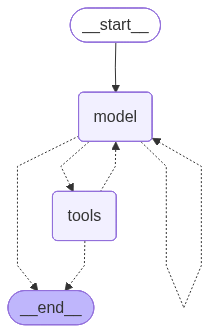

In [374]:
agent

In [375]:
for message in result['messages']:
    print(message.pretty_print())

================================ Human Message =================================

Recommend movies for the user 5
None
================================== Ai Message ==================================
Tool Calls:
  GetUserHistory (call_LfWXst7kEvQbtLbEKEa8SvnP)
 Call ID: call_LfWXst7kEvQbtLbEKEa8SvnP
  Args:
    user_id: 5
None
================================= Tool Message =================================
Name: GetUserHistory

One Flew Over the Cuckoo's Nest, Star Wars: Episode I - The Phantom Menace, Galaxy Quest, Flight of the Navigator, Twelve Monkeys, Contact, The Matrix, Star Trek VI: The Undiscovered Country, Star Trek: First Contact, Sneakers, The Fifth Element, Men in Black, Star Trek: Generations, Star Trek: Insurrection, Back to the Future, Star Wars: Episode V - The Empire Strikes Back, E.T. the Extra-Terrestrial, Blade Runner, Star Trek: The Wrath of Khan, Star Wars: Episode VI - Return of the Jedi, Star Trek III: The Search for Spock, The Fly, Star Trek IV: The Voyage Hom

In [376]:
result['structured_response']

RecommendationResponse(user_id=5, recommendations=['The Silence of the Lambs', 'American Beauty', 'Saving Private Ryan', 'The Sixth Sense', 'L.A. Confidential', 'The Usual Suspects', 'Terminator 2: Judgment Day', 'The Princess Bride', 'Back to the Future', 'Star Wars: Episode IV - A New Hope'])

In [377]:
result['preferences']

"Based on your viewing history, your preferences suggest you favor:\n\n1. **Science Fiction & Fantasy**: You enjoy mind-bending, futuristic worlds (e.g., *The Matrix*, *Blade Runner*, *Contact*, *The Fifth Element*, *Tron*), as well as space epics and interstellar adventures (*Star Wars*, *Star Trek* series, *Galaxy Quest*).\n\n2. **Thought-Provoking & Philosophical Themes**: Films with deep, existential questions (*Nineteen Eighty-Four*, *Schindler's List*, *Life Is Beautiful*) and complex narratives.\n\n3. **Classic & Cult Cinema**: Many iconic, influential movies from different eras (e.g., *One Flew Over the Cuckoo's Nest*, *Pulp Fiction*, *Back to the Future*) indicating an appreciation for groundbreaking or highly regarded films.\n\n4. **Drama & Human Condition**: Films exploring moral dilemmas, human resilience, and social issues (*The Shawshank Redemption*, *Good Will Hunting*, *Fargo*, *Life Is Beautiful*).\n\n5. **Science & Technology**: Interest in movies involving scientific

In [ ]:
result["recommended_items"]

['Forrest Gump (1994)',
 'Matrix, The (1999)',
 'Star Trek: Insurrection (1998)',
 'Star Trek: The Wrath of Khan (1982)',
 'Apollo 13 (1995)',
 'Total Recall (1990)',
 'Jurassic Park (1993)',
 'Independence Day (ID4) (1996)',
 'Gattaca (1997)',
 'Truman Show, The (1998)']

In [387]:
result

{'messages': [HumanMessage(content='Recommend movies for the user 5', additional_kwargs={}, response_metadata={}, id='d9387d53-19ad-4a45-bdf7-961a72e83ed7'),
  AIMessage(content='', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 16, 'prompt_tokens': 407, 'total_tokens': 423, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4.1-nano-2025-04-14', 'system_fingerprint': 'fp_1f35c1788c', 'id': 'chatcmpl-CRsZk87vfwz4G1S5UtLvIxFNckMRO', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='lc_run--eb87390f-fe3d-4e96-809f-7ae740857dbf-0', tool_calls=[{'name': 'GetUserHistory', 'args': {'user_id': 5}, 'id': 'call_LfWXst7kEvQbtLbEKEa8SvnP', 'type': 'tool_call'}], usage_metadata={'input_tokens': 407, 'output_tokens': 16, 'to

In [383]:
resp : RecommendationResponse = result['structured_response']
resp

RecommendationResponse(user_id=5, recommendations=['Forrest Gump', 'The Matrix', 'Star Trek: Insurrection', 'Star Trek: The Wrath of Khan', 'Apollo 13', 'Total Recall', 'Jurassic Park', 'Independence Day (ID4)', 'Gattaca', 'The Truman Show'])

In [348]:
def recall_at_n_test(recommendation_list, N):
  original_recommended_titles = [ updated_to_original_titles[recommended_movies] for recommended_movies in recommendation_list]
  recommended_raw_item_ids = backbones.get_raw_item_ids_from_titles_in_catalog(original_recommended_titles)
  raw_target_user_id = get_raw_user_ids(ratings_pp, [resp.user_id])[0]

  max_relevant_items = min( test_ratings[(test_ratings.User_id == raw_target_user_id)].shape[0], N )
  max_relevant_items = max_relevant_items if max_relevant_items != 0 else 1 # Avoid division by zero
  n_relevant_items = test_ratings[(test_ratings.User_id == raw_target_user_id) & (test_ratings.Item_id.isin(recommended_raw_item_ids)) ].shape[0]

  return n_relevant_items / max_relevant_items

recall_at_n_test(resp.recommendations,10)

0.0

In [337]:
raw_target_user_id = get_raw_user_ids(ratings_pp, [resp.user_id])[0]
test_ratings[(test_ratings.User_id == raw_target_user_id)]

,User_id,Item_id,Rating,Timestamp,Gender,datetime


## Tentativa usar métricas prontas

In [252]:
recommended_raw_item_ids

[50, 912, 1198, 1207, 1221, 1225, 1267, 1288, 1952, 2019]

In [253]:
new_predictions = backbones.predictions['ease'].copy()

In [254]:
print("Pred before")
new_predictions

Pred before


array([[           -inf,            -inf,            -inf, ...,
        -1.34675298e-03,  1.19010208e-03, -7.87241210e-04],
       [           -inf,  3.01030248e-02,  5.64953503e-02, ...,
         2.35601154e-04, -2.62963702e-04, -1.41962210e-03],
       [ 1.89055543e-02,  6.87062565e-03,  2.47792807e-02, ...,
        -5.53260208e-04, -8.11758335e-04,  9.74050708e-05],
       ...,
       [ 5.88292774e-02,  6.75608575e-03,            -inf, ...,
         2.06903578e-03, -6.84450497e-04,  3.40562593e-03],
       [ 4.53292436e-02,  1.35395328e-02,  5.66198775e-02, ...,
        -2.15279707e-03,  1.70515763e-04, -5.57394000e-04],
       [ 1.30901894e-01,  5.95803249e-02,  1.41266910e-01, ...,
        -4.35068388e-04,  8.53946724e-04, -4.23912948e-04]])

In [255]:
new_predictions[resp.user_id][recommended_inner_item_ids]

array([0.32979145, 0.53700863, 0.43868644, 0.43332533, 0.4059249 ,
       0.43185308, 0.38653825, 0.40999317, 0.38153146, 0.32910677])

In [256]:
print("Pred after")
new_predictions[resp.user_id][recommended_inner_item_ids] = 5.1 # set high score to recommended items
new_predictions[resp.user_id][recommended_inner_item_ids]


Pred after


array([5.1, 5.1, 5.1, 5.1, 5.1, 5.1, 5.1, 5.1, 5.1, 5.1])

In [257]:
backbones.scenario.test_data_out.binary_values

<Compressed Sparse Row sparse matrix of dtype 'int32'
	with 112609 stored elements and shape (6038, 3533)>

In [258]:
recall_at_n(new_predictions,backbones.scenario.test_data_out.binary_values, 10)

/Users/eas/Documents/GitHub/fair_neighborhood/src/helper_functions/metrics_accuracy.py:34: RuntimeWarning: invalid value encountered in divide
  recall = (np.logical_and(R_held_binary, R_hat_binary).sum(axis=1)).astype(np.float32) / np.minimum(n, R_held_binary.sum(axis=1))


(nan, nan)

In [259]:
recall_at_n(backbones.predictions['ease'],backbones.scenario.test_data_out.binary_values, 10)

/Users/eas/Documents/GitHub/fair_neighborhood/src/helper_functions/metrics_accuracy.py:34: RuntimeWarning: invalid value encountered in divide
  recall = (np.logical_and(R_held_binary, R_hat_binary).sum(axis=1)).astype(np.float32) / np.minimum(n, R_held_binary.sum(axis=1))


(nan, nan)

In [176]:
raw_target_user_id = get_raw_user_ids(ratings_pp, [resp.user_id])[0]
test_ratings[test_ratings.User_id == raw_target_user_id]


,User_id,Item_id,Rating,Timestamp,Gender,datetime
933457,6040,3182,5,984195682,0,2001-03-10 03:41:22
958478,6040,2575,4,997453762,0,2001-08-10 14:29:22
958479,6040,1212,5,997453796,0,2001-08-10 14:29:56
958480,6040,3362,4,997453796,0,2001-08-10 14:29:56
958481,6040,1258,4,997453909,0,2001-08-10 14:31:49
958482,6040,3421,3,997453909,0,2001-08-10 14:31:49
958483,6040,1270,3,997453960,0,2001-08-10 14:32:40
958484,6040,2068,4,997453982,0,2001-08-10 14:33:02
958485,6040,1947,4,997454036,0,2001-08-10 14:33:56
958486,6040,1211,5,997454080,0,2001-08-10 14:34:40


In [158]:
original_recommended_titles

['Godfather, The (1972)',
 'Casablanca (1942)',
 "Schindler's List (1993)",
 'Pulp Fiction (1994)',
 'North by Northwest (1959)',
 'Amadeus (1984)',
 'Star Wars: Episode V - The Empire Strikes Back (1980)',
 'Matrix, The (1999)',
 'Toy Story (1995)',
 '12 Angry Men (1957)']

In [149]:
[ updated_to_original_titles[recommended_movies] for recommended_movies in resp.recommendations]

# for resp in resp.recommendations:
#     print(resp)
#     print(updated_to_original_titles[resp])

['Godfather, The (1972)',
 'Casablanca (1942)',
 "Schindler's List (1993)",
 'Pulp Fiction (1994)',
 'North by Northwest (1959)',
 'Amadeus (1984)',
 'Star Wars: Episode V - The Empire Strikes Back (1980)',
 'Matrix, The (1999)',
 'Toy Story (1995)',
 '12 Angry Men (1957)']

## Cinstr

In [3]:
# Cinstr: System/Agent Instructions
def get_agent_instruction(agent_role):
    instructions = {
        'filter': 'Filter candidate items from backbone models.',
        'preference': 'Extract user preferences from interactions.',
        'rerank': 'Rerank items based on user preferences and context.',
        # Add more agent roles as needed
    }
    return instructions.get(agent_role, 'No instruction defined.')

## Cknow

In [20]:
# Cknow: External Knowledge Integration
def fetch_external_knowledge(item_ids):
    # Return a dict of item_id -> knowledge
    # Example:
    return {item_id: {'genre': 'Drama', 'rating': 3.5} for item_id in item_ids}

In [21]:
# Ctools: Information Extraction/Generation
def extract_relevant_info(items, knowledge):
    # Example: Extract genres, ratings, etc.
    return [knowledge[item]['genre'] for item in items]

In [22]:
# Cmem: Memory Management
class Memory:
    def __init__(self):
        self.short_term = []
        self.long_term = []
    def store_interaction(self, interaction, term='short'):
        if term == 'short':
            self.short_term.append(interaction)
        else:
            self.long_term.append(interaction)
    def get_memory(self, term='short'):
        return self.short_term if term == 'short' else self.long_term

In [23]:
# Cstate: State Tracking
class State:
    def __init__(self):
        self.steps_done = []
        self.current_candidates = []
    def update(self, step, candidates=None):
        self.steps_done.append(step)
        if candidates is not None:
            self.current_candidates = candidates

In [24]:
# Cquery: User Query Handling
def parse_user_query(query):
    # Example: Parse for fairness, diversity, etc.
    if 'fairness' in query.lower():
        return {'objective': 'fairness'}
    return {'objective': 'default'}

## 2. Backbone Model Candidate Generation
Generate candidate recommendations using backbone models.

In [93]:
im_train.binary_values.toarray()

array([[1, 1, 1, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)

In [ ]:
# Simplest backbone
def collaborative_filtering():
    pass

In [ ]:
def generate_candidates(user_id, backbone_model):
    # Example: Use backbone_model to get top-N candidates for user_id
    return ['item1', 'item2', 'item3']

## 3. User Preference Extraction
Extract user preferences from historical data or interactions.

In [ ]:
def get_user_preferences(user_id, memory):
    # Example: Aggregate preferences from memory
    return {'genre': 'Drama', 'rating_min': 7.0}

## 4. Reranking with Context Engineering
Rerank candidates using user preferences and context elements.

In [ ]:
def rerank_candidates(candidates, preferences, knowledge, query_context):
    # Example: Rerank based on genre match and fairness objective
    reranked = sorted(candidates, key=lambda x: knowledge[x]['rating'], reverse=True)
    return reranked

## 5. Evaluation & Results
Evaluate the final recommendations and display results.

In [ ]:
# Example pipeline execution
user_id = 42
backbone_model = 'mf_fair'  # Example backbone
memory = Memory()
state = State()
query = 'Equilibrate fairness in the recommendations'

# Step 1: Generate candidates
candidates = generate_candidates(user_id, backbone_model)
state.update('generated_candidates', candidates)

# Step 2: Fetch external knowledge
knowledge = fetch_external_knowledge(candidates)

# Step 3: Extract user preferences
preferences = get_user_preferences(user_id, memory)

# Step 4: Parse user query
query_context = parse_user_query(query)

# Step 5: Rerank candidates
final_recommendations = rerank_candidates(candidates, preferences, knowledge, query_context)
state.update('reranked_candidates', final_recommendations)

# Display results
print('Final Recommendations:', final_recommendations)